# Введение

Одной из ключевых проблем при обучении с подкреплением является балансировка между максимизацией награды и регуляризацией модели. Высокая награда может привести к переобучению, в то время как сильная регуляризация может снизить производительность модели. Для решения этой проблемы был предложен метод WARP

WARP оптимизирует фронт Парето для KL-награды, что позволяет достичь оптимального баланса между максимизацией награды и минимизацией KL-дивергенции. Это помогает избежать переобучения и улучшить обобщающую способность модели.




In [1]:
!pip install datasets transformers trl torch numpy matplotlib

In [2]:
import logging
logging.disable(logging.WARNING)

Шаг 1. Составим необходимый нам датасет

In [3]:
from datasets import load_dataset
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import random

dataset = load_dataset("imdb")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

positive_comments = [x['text'] for x in train_dataset if x['label'] == 1]
negative_comments = [x['text'] for x in train_dataset if x['label'] == 0]

num_pairs = 10000  # значение можно варьировать, зависит от оперативной памяти в наличии
pairs = [(random.choice(positive_comments), random.choice(negative_comments)) for _ in range(num_pairs)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Шаг 2. Скачиваем предобученную reward функцию согласно заданию

In [4]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import random

reward_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")

Шаг 3. Добучаем нашу reward функцию. Значение для количества эпох подбираем сами

Epoch: 1, Average Loss: 0.0021233094575528414
Epoch: 2, Average Loss: 1.545666011480762e-07
Epoch: 3, Average Loss: 6.756775994247732e-08
Training complete.


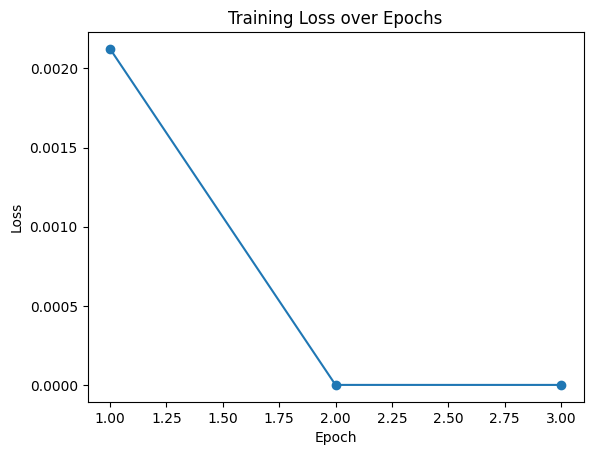

In [5]:
class PairsDataset(Dataset):
    def __init__(self, pairs, tokenizer):
        self.pairs = pairs
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pos_comment, neg_comment = self.pairs[idx]
        inputs = self.tokenizer(pos_comment, neg_comment, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = torch.tensor(1)
        return inputs

train_dataset = PairsDataset(pairs, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = torch.optim.AdamW(reward_model.parameters(), lr=5e-5)

reward_model.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model.to(device)

num_epochs = 3  # даннное число выбрано эксперементально, далее модели выходят на плато
loss_values = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        labels = inputs.pop('labels')
        outputs = reward_model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Average Loss: {avg_loss}")

print("Training complete.")

plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [6]:
output_dir = "./saved_model"
reward_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

Шаг 4. SFT модель берем также предобученную согласно заданию

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

sft_tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
sft_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")

Шаг 5. Подготавливаем нашу обучающую выборку

In [8]:
original_dataset = dataset["train"]

prompts = [x['text'][:15] for x in original_dataset]

Шаг 6. Релазиуем WAPR алгоритм согласно тексту статьи
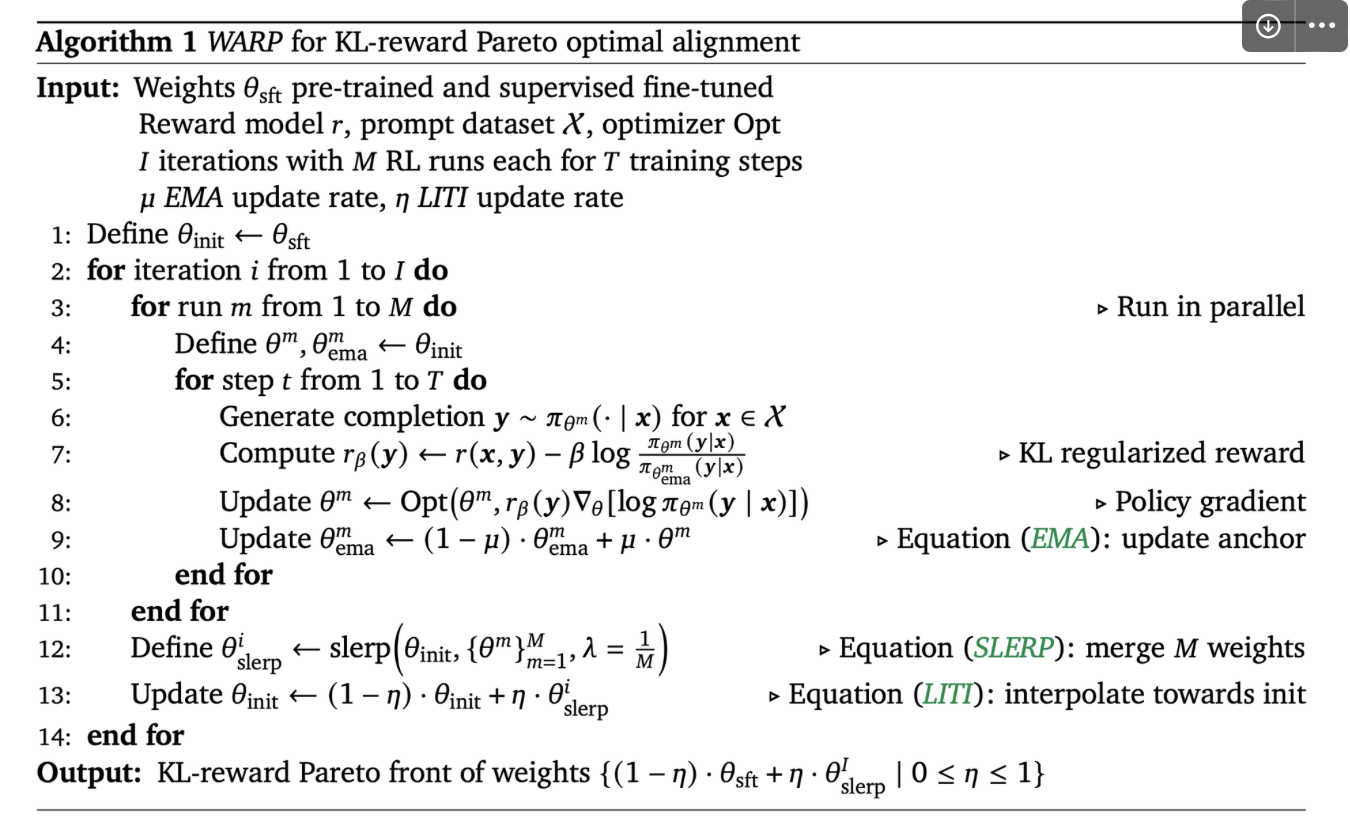

Использование EMA помогает сгладить резкие изменения в политике модели, что приводит к более стабильному процессу обучения. Это особенно важно при обучении с подкреплением, где нестабильность может привести к значительным потерям в производительности.

In [9]:
import torch
import logging
import copy
from typing import Any

class WARPTrainer:
    def __init__(
        self,
        sft_model: torch.nn.Module,
        reward_model: torch.nn.Module,
        sft_tokenizer: Any,
        tokenizer: Any,
        device: torch.device,
        I: int = 2,
        M: int = 2,
        T: int = 100,
        μ: float = 0.01,
        η: float = 0.5,
        lr: float = 1e-5,
    ) -> None:
        self._sft_model = sft_model.to(device)
        self._reward_model = reward_model.to(device)
        self._sft_tokenizer = sft_tokenizer
        self._tokenizer = tokenizer
        self._device = device
        self._I = I
        self._M = M
        self._T = T
        self._μ = μ
        self._η = η
        self._optimizer = torch.optim.AdamW(self._sft_model.parameters(), lr=lr)
        self._θ_init = self._sft_model.state_dict()

    @property
    def sft_model(self) -> torch.nn.Module:
        return self._sft_model

    def _update_model(
        self,
        inputs: dict[str, torch.Tensor],
        reward: torch.Tensor,
    ) -> None:
        self._sft_model.train()
        self._optimizer.zero_grad()
        outputs = self._sft_model(**inputs)
        loss = -reward
        loss.backward()
        optimizer.step()

    def _slerp(
        self,
        val: float,
        low: torch.Tensor,
        high: torch.Tensor,
        epsilon: float = 1e-10,
    ) -> torch.Tensor:
        low_norm = low / (
            torch.norm(low, dim=-1, keepdim=True) + epsilon
        )
        high_norm = high / (torch.norm(high, dim=-1, keepdim=True) + epsilon)
        dot_product = torch.sum(low_norm * high_norm, dim=-1, keepdim=True)
        dot_product = torch.clamp(dot_product, -1.0, 1.0)
        omega = torch.acos(dot_product)
        so = torch.sin(omega)
        slerp_result = (
            torch.sin((1.0 - val) * omega) / (so + epsilon) * low +
                        torch.sin(val * omega) / (so + epsilon) * high)

        return slerp_result.squeeze()

    def _train_step(self, prompts: list[str]) -> None:
        for prompt in prompts[:3]:  # количество промтом можно менять в зависимсоти от имеющихся ресурсов
            inputs = self._sft_tokenizer(
                prompt,
                return_tensors="pt",
            ).to(self._device)

            outputs = self._sft_model.generate(**inputs)

            # декодируем первый элемент из сгенерированных выходных данных

            completion = self._sft_tokenizer.decode(
                outputs[0],
                skip_special_tokens=True,
            )

            # токенизируем сгенерированный текст

            reward_inputs = self._tokenizer(
                completion,
                return_tensors="pt",
            ).to(self._device)

            # пропускаем токенизированные данные через модель вознаграждения

            reward_outputs = self._reward_model(**reward_inputs)

            # вычисляем среднее значение логитов из выходных данных модели вознаграждения

            reward = reward_outputs.logits.mean()

            # обновляем модель, используя входные данные и вычисленное вознаграждение

            self._update_model(
                inputs,
                reward,
            )

    def _update_ema(
        self,
        θ_m: dict[str, torch.Tensor],
        θ_m_ema: dict[str, torch.Tensor],
    ) -> dict[str, torch.Tensor]:
        """
        Метод сглаживания данных, который придает больший вес последним наблюдениям, уменьшая влияние старых данных
        """
        for key in θ_m_ema:
            θ_m_ema[key] = (1 - self._μ) * θ_m_ema[key] + self._μ * θ_m[key]

        return θ_m_ema

    def _slerp_models(
        self,
        θ_m_list: list[dict[str, torch.Tensor]]
    ) -> dict[str, torch.Tensor]:
        """
        Метод интерполяции между двумя точками на сфере для плавного перехода между ними
        """
        θ_i_slerp = copy.deepcopy(θ_m_list[0])

        for key in θ_i_slerp:
            θ_i_slerp[key] = sum(
                self._slerp(
                    1/self._M, θ_m_list[m][key], θ_m_list[(m+1) % self._M][key]
                ) for m in range(self._M)
            )

        return θ_i_slerp

    def _update_initial_model(
        self,
        θ_i_slerp: dict[str, torch.Tensor]
    ) -> None:
        """
        это метод линейной интерполяции, который используется для плавного
        перехода от объединенной модели к исходной инициализации
        """
        self._θ_init = {
            key: (1 - self._η) * self._θ_init[key] + self._η * θ_i_slerp[key]
            for key in θ_i_slerp
        }

        self._sft_model.load_state_dict(self._θ_init)

    def train(self, prompts: list[str]) -> None:
        for i in range(self._I):
            print(f"Starting iteration {i+1}/{self._I}")

            θ_m_list = []

            for m in range(self._M):
                print(f" Starting run {m+1}/{self._M}")

                θ_m = copy.deepcopy(self._θ_init)
                θ_m_ema = copy.deepcopy(θ_m)

                for t in range(self._T):
                    if t % 10 == 0:
                        print(f" Step {t+1}/{self._T}")

                    self._train_step(prompts)

                θ_m_ema = self._update_ema(θ_m, θ_m_ema)
                θ_m_list.append(θ_m_ema)

            θ_i_slerp = self._slerp_models(θ_m_list)

            self._update_initial_model(θ_i_slerp)

            print(f"Completed iteration {i+1}/{self._I}")

Шаг 7. Обучим нашу модель

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = WARPTrainer(
    sft_model,
    reward_model,
    sft_tokenizer,
    tokenizer,
    device,
)
trainer.train(prompts)

Starting iteration 1/2
 Starting run 1/2
 Step 1/100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 1/2
Starting iteration 2/2
 Starting run 1/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 2/2


In [11]:
test_prompts = [x['text'][:20] for x in random.sample(list(test_dataset), 100)]

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM

sft_tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
original_sft_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")

Шаг 8. Реализуем метод для оценки reward и KL дивергенции модели

In [13]:
import torch
import numpy as np
from typing import Any

class WARPModelEvaluator:
    def __init__(
        self,
        sft_model: torch.nn.Module,
        reward_model: torch.nn.Module,
        sft_tokenizer: Any,
        tokenizer: Any,
        device: torch.device,
    ) -> None:
        self._sft_model = sft_model.to(device)
        self._reward_model = reward_model.to(device)
        self._sft_tokenizer = sft_tokenizer
        self._tokenizer = tokenizer
        self._device = device

    def _generate_text_and_logits(
        self,
        model: torch.nn.Module,
        inputs: dict[str, torch.Tensor],
    ) -> tuple[torch.Tensor, torch.Tensor]:
        outputs = model.generate(
            **inputs,
            output_scores=True,
            return_dict_in_generate=True,
        )
        generated_tokens = outputs.sequences
        generated_logits = torch.stack(
            outputs.scores,
            dim=1,
        ).to(self._device)

        return generated_tokens, generated_logits

    def _evaluate_reward(self, completion: str) -> float:
        reward_inputs = self._tokenizer(
            completion,
            return_tensors="pt"
        ).to(self._device)

        reward_outputs = self._reward_model(**reward_inputs)

        reward = reward_outputs.logits.mean().item()
        return reward

    def _evaluate_kl_divergence(
        self,
        inputs: dict[str, torch.Tensor],
        generated_logits: torch.Tensor,
    ) -> float:
        sft_outputs = self._sft_model(**inputs)

        sft_logits = sft_outputs.logits[
            :, :generated_logits.size(1), :
        ].to(self._device)

        min_length = min(generated_logits.size(1), sft_logits.size(1))
        generated_logits = generated_logits[:, :min_length, :]
        sft_logits = sft_logits[:, :min_length, :]

        epsilon = 1e-10
        generated_logits = torch.log_softmax(
            generated_logits.float() + epsilon,
            dim=-1,
        )
        sft_logits = torch.softmax(sft_logits.float() + epsilon, dim=-1)

        kl = torch.nn.functional.kl_div(
            generated_logits,
            sft_logits,
            reduction='batchmean'
        ).item()

        return kl

    def evaluate_model(
        self,
        model: torch.nn.Module,
        prompts: list[str]
    ) -> tuple[float, float]:
        rewards = []
        kls = []
        model.to(self._device)

        for prompt in prompts:
            inputs = self._sft_tokenizer(
                prompt,
                return_tensors="pt",
            ).to(self._device)
            generated_tokens, generated_logits = self._generate_text_and_logits(
                model,
                inputs,
              )
            completion = self._sft_tokenizer.decode(
                generated_tokens[0],
                skip_special_tokens=True,
            )

            reward = self._evaluate_reward(completion)
            kl = self._evaluate_kl_divergence(inputs, generated_logits)

            rewards.append(reward)
            kls.append(kl)

        return np.mean(rewards), np.mean(kls)

Шаг 9. Cравним метрики для обычной модели и для обученной

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

evaluator = WARPModelEvaluator(
    sft_model,
    reward_model,
    sft_tokenizer,
    tokenizer,
    device,
)

mean_reward_trained, mean_kl_trained = evaluator.evaluate_model(
    trainer.sft_model,
    test_prompts,
)
mean_reward, mean_kl = evaluator.evaluate_model(
    original_sft_model,
    test_prompts,
)

print(
    f"Original Model - Average Reward: {mean_reward}, Average KL: {mean_kl}"
)

print(
    f"Trained Model - Average Reward: {mean_reward_trained}, Average KL: {mean_kl_trained}"
)

Original Model - Average Reward: 9740.819384765626, Average KL: 35.32365525245667
Trained Model - Average Reward: 9795.950224609374, Average KL: 0.8695373547077179


Шаг 10. Согласно заданию, параметризуем один из гиперпараметров и сравним качество модели при вариации этого параметра

Starting iteration 1/2
 Starting run 1/2
 Step 1/100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 1/2
Starting iteration 2/2
 Starting run 1/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 2/2
Starting iteration 1/2
 Starting run 1/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 1/2
Starting iteration 2/2
 Starti

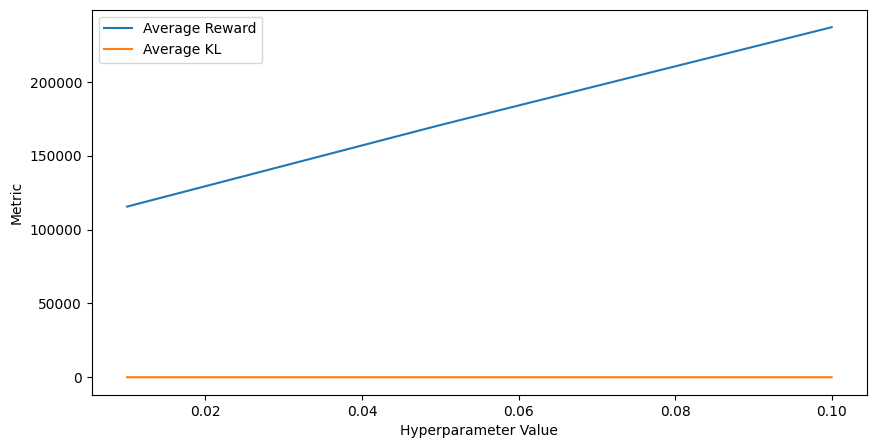

In [ ]:
import torch
import matplotlib.pyplot as plt

hyperparameter_values = [0.01, 0.05, 0.1]
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for μ in hyperparameter_values:
  trainer = WARPTrainer(
    sft_model,
    reward_model,
    sft_tokenizer,
    tokenizer,
    device,
    μ=μ,
  )
  trainer.train(prompts)

  evaluator = WARPModelEvaluator(
    original_sft_model,
    reward_model,
    sft_tokenizer,
    tokenizer,
    device,
  )

  rewards, kls = evaluator.evaluate_model(
      trainer.sft_model,
      test_prompts,
  )

  results.append((μ, rewards, kls))


values, rewards, kls = zip(*results)
plt.figure(figsize=(10, 5))
plt.plot(values, rewards, label='Average Reward')
plt.plot(values, kls, label='Average KL')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [15]:
trainer_changed_hyperparam = WARPTrainer(
    sft_model,
    reward_model,
    sft_tokenizer,
    tokenizer,
    device,
    μ=0.1,
  )
trainer_changed_hyperparam.train(prompts)


mean_reward_changed_hyperaram, mean_kl_changed_hyperparam = evaluator.evaluate_model(
    trainer_changed_hyperparam.sft_model,
    test_prompts,
)

print(
    f"Model with changed hyperparam- Average Reward: {mean_reward_changed_hyperaram}, Average KL: {mean_kl_changed_hyperparam}"
)

Starting iteration 1/2
 Starting run 1/2
 Step 1/100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 1/2
Starting iteration 2/2
 Starting run 1/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
 Starting run 2/2
 Step 1/100
 Step 11/100
 Step 21/100
 Step 31/100
 Step 41/100
 Step 51/100
 Step 61/100
 Step 71/100
 Step 81/100
 Step 91/100
Completed iteration 2/2
Model with changed hyperparam- Average Reward: 29285.20220703125, Average KL: 0.03205839280504733


Шаг 11. Модифицируем архитектуру WARP, использую RLOO из back to basics cтатьи


RLOO — это метод оценки, при котором для каждого образца вычисляется его вклад в общую оценку, исключая его самого. Это позволяет уменьшить смещение и повысить устойчивость оценки.

In [16]:
import torch
import copy

class WARPTrainerWithChanges:
    def __init__(
        self,
        sft_model: torch.nn.Module,
        reward_model: torch.nn.Module,
        sft_tokenizer: Any,
        tokenizer: Any,
        device: torch.device,
        I: int = 2,
        M: int = 2,
        T: int = 100,
        μ: float = 0.01,
        η: float = 0.5,
        lr: float = 1e-5,
        k: int = 5,  # количество онлайн семплов для rloo
    ) -> None:
        self._sft_model = sft_model.to(device)
        self._reward_model = reward_model.to(device)
        self._sft_tokenizer = sft_tokenizer
        self._tokenizer = tokenizer
        self._device = device
        self._I = I
        self._M = M
        self._T = T
        self._μ = μ
        self._η = η
        self._k = k
        self._optimizer = torch.optim.AdamW(self._sft_model.parameters(), lr=lr)
        self._θ_init = self._sft_model.state_dict()

    @property
    def sft_model(self) -> torch.nn.Module:
        return self._sft_model

    def _update_model(self, inputs: dict[str, torch.Tensor], reward: torch.Tensor, retain_graph: bool = False) -> None:
        self._sft_model.train()
        self._optimizer.zero_grad()
        outputs = self._sft_model(**inputs)
        loss = -reward
        loss.backward(retain_graph=retain_graph)
        self._optimizer.step()

    def _slerp(self, val: float, low: torch.Tensor, high: torch.Tensor, epsilon: float = 1e-10) -> torch.Tensor:
        low_norm = low / (torch.norm(low, dim=-1, keepdim=True) + epsilon)
        high_norm = high / (torch.norm(high, dim=-1, keepdim=True) + epsilon)
        dot_product = torch.sum(low_norm * high_norm, dim=-1, keepdim=True)
        dot_product = torch.clamp(dot_product, -1.0, 1.0)
        omega = torch.acos(dot_product)
        so = torch.sin(omega)
        slerp_result = (
            torch.sin((1.0 - val) * omega) / (so + epsilon) * low +
            torch.sin(val * omega) / (so + epsilon) * high
        )
        return slerp_result.squeeze()

    def _train_step(self, prompts: list[str]) -> None:
        for prompt in prompts[:3]:
            inputs = self._sft_tokenizer(prompt, return_tensors="pt").to(self._device)
            completions = []
            rewards = []

            for _ in range(self._k):
                outputs = self._sft_model.generate(**inputs)
                completion = self._sft_tokenizer.decode(outputs[0], skip_special_tokens=True)
                completions.append(completion)

                reward_inputs = self._tokenizer(completion, return_tensors="pt").to(self._device)
                reward_outputs = self._reward_model(**reward_inputs)
                reward = reward_outputs.logits.mean()
                rewards.append(reward)

            for i in range(self._k):
                # вычисляем baseline как среднее значение наград остальных образцов
                baseline = sum(rewards[j] for j in range(self._k) if j != i) / (self._k - 1)

                # корректируем награду, вычитая  baseline
                adjusted_reward = rewards[i] - baseline

                # определяем, нужно ли сохранять граф вычислений
                retain_graph = i < self._k - 1

                # обновляем параметры модели
                self._update_model(inputs, adjusted_reward, retain_graph=retain_graph)

    def _update_ema(self, θ_m: dict[str, torch.Tensor], θ_m_ema: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        """
        Метод сглаживания данных, который придает больший вес последним наблюдениям, уменьшая влияние старых данных
        """
        for key in θ_m_ema:
            θ_m_ema[key] = (1 - self._μ) * θ_m_ema[key] + self._μ * θ_m[key]
        return θ_m_ema

    def _slerp_models(self, θ_m_list: list[dict[str, torch.Tensor]]) -> dict[str, torch.Tensor]:
        """
        Метод интерполяции между двумя точками на сфере для плавного перехода между ними
        """
        θ_i_slerp = copy.deepcopy(θ_m_list[0])
        for key in θ_i_slerp:
            θ_i_slerp[key] = sum(
                self._slerp(1/self._M, θ_m_list[m][key], θ_m_list[(m+1) % self._M][key])
                for m in range(self._M)
            )
        return θ_i_slerp

    def _update_initial_model(self, θ_i_slerp: dict[str, torch.Tensor]) -> None:
        """
        Это метод линейной интерполяции, который используется для плавного
        перехода от объединенной модели к исходной инициализации
        """
        self._θ_init = {
            key: (1 - self._η) * self._θ_init[key] + self._η * θ_i_slerp[key]
            for key in θ_i_slerp
        }
        self._sft_model.load_state_dict(self._θ_init)

    def train(self, prompts: list[str]) -> None:
        for i in range(self._I):

            print(f"Starting iteration {i+1}/{self._I}")

            θ_m_list = []

            for m in range(self._M):
                print(f" Starting run {m+1}/{self._M}")

                θ_m = copy.deepcopy(self._θ_init)

                θ_m_ema = copy.deepcopy(θ_m)

                for t in range(self._T):

                    if t % 10 == 0:
                        print(f" Step {t+1}/{self._T}")

                    self._train_step(prompts)

                    θ_m_ema = self._update_ema(θ_m, θ_m_ema)

                θ_m_list.append(θ_m_ema)

            θ_i_slerp = self._slerp_models(θ_m_list)

            self._update_initial_model(θ_i_slerp)

            print(f"Completed iteration {i+1}/{self._I}")

В методе RLOO награды корректируются путем вычитания базовой линии (baseline), которая является средним значением наград остальных образцов. Поэтому, награда при исползовании RLOO может быть ниже.

Данную модель обучать не стал, так как потребуется больше ресурсов.

Шаг 12. Отобразим на графике все reward и KL дивергенции

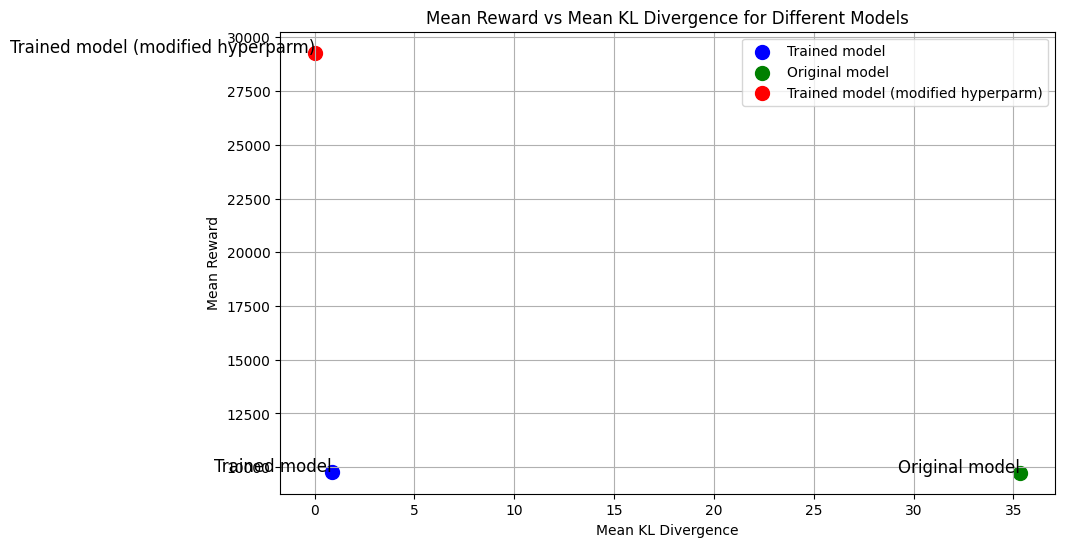

In [21]:
import matplotlib.pyplot as plt

mean_rewards = [mean_reward_trained, mean_reward, mean_reward_changed_hyperaram]
mean_kls = [mean_kl_trained, mean_kl, mean_kl_changed_hyperparam]
model_labels = ['Trained model', 'Original model', 'Trained model (modified hyperparm)']

colors = ['blue', 'green', 'red']

plt.figure(figsize=(10, 6))

for i in range(len(mean_rewards)):
    plt.scatter(mean_kls[i], mean_rewards[i], color=colors[i], s=100, label=model_labels[i])

for i, label in enumerate(model_labels):
    plt.text(mean_kls[i], mean_rewards[i], label, fontsize=12, ha='right')

plt.xlabel('Mean KL Divergence')
plt.ylabel('Mean Reward')
plt.title('Mean Reward vs Mean KL Divergence for Different Models')
plt.grid(True)

plt.legend()

plt.show()

Анализируя график, можно заметить, что reward и обученной модели и базовой почти одинаокв, однако KL дивергенция ниже в результате спользования WARP. У модели, у которой мы варьировали гиперпаратметры, reward значительно увеличен.

# Заключение

Таким образом, метод WARP представляет собой перспективный подход к обучению больших языковых моделей, который сочетает в себе стабильность, гибкость и высокое качество генерации. Использование EMA, SLERP и LITI позволяет достичь оптимального баланса между наградой и регуляризацией, что делает этот метод особенно полезным для сложных задач, требующих высокой точности и надежности.



В какую сторону бы двигался далее в исследованиях:

1. Настройка гиперпараметров. Так как они наиболее сильно влияют на итоговое качество модели я бы потратил силы на поиск оптимальных гиперпараметров если нам нужно production решение. Однако, насколько мне известно, можно дианамически их варьировать в процессе обучения.


2.  Комбинация с RL решениями. Хотя WARP призван отказаться от традиционных RL методов, таких как PPO, их можно использовать для предварительного обучения или в качестве вспомогательных методов. Например, можно использовать PPO для предварительного обучения модели, а затем применять WARP для тонкой настройки и стабилизации.

3. Использование сложной reward-функции. Можно использовать что-то вроде Mixture of Experts для reward фунции